<a href="https://colab.research.google.com/github/ravenousr/ISLR-python/blob/master/Copy_of_May28_Prediction_of_stock_market_index_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Project: Prediction of stock market index using LSTM**

**Compiled by**: Hum Nath Bhandari, Binod Rimal


# **Part I:  Data Creation and Exploration**

In this module we use various financial resources to create input data for our machine learning models. This includes the following data.
- S\&P 500 index data: Open price, Close price, and  Volume
- Vix index
- Interest Rate 
- Unemployment Rate
- Consumer sentiment index

Our data will be the time series data with the following start and end date.

- start date: 2006/01/02
- end date:  2020/11/30


### **Importing basic libraries and APIs** 

In [ ]:

import pandas as pd  ##import necessary libraries
import numpy as np
import math
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_theme(style="whitegrid")
plt.style.use('ggplot')


import tensorflow as tf
%load_ext tensorboard

import warnings
warnings.filterwarnings('ignore')

import os
import datetime as dt
import pandas_datareader.data as web

!pip install fredapi
from fredapi import Fred
fred = Fred(api_key='b9bebe3287b6308adffe3f8ab7e675ae')
#fred.search('10-year U.S tresury')

### **Extracting data from various sources**

In [ ]:
def get_stock_and_indicators(ticker, data_source, start_date, end_date, window_length): # indicator window length = 14 by default
  data  =  web.DataReader(ticker, data_source, start_date, end_date)[['High', 'Low','Open','Close', 'Volume']]
  data  =  data.fillna(method='bfill') #backward fill for NaN

  close = data['Close']

  ##################################################################

  ###Calculating MACD###############################################
  exp12=close.ewm(span=12,adjust=False).mean()
  exp26=close.ewm(span=26,adjust=False).mean()
  macd=exp26-exp12
  data['MACD']=macd

  ################## Calculating RSI ########################################
  #To get the difference in the price from the previous step
  delta = close.diff()
  # Get rid of the first row which is nan since it did not have the previous row to calculate the diference
  delta = delta[1:]
  #To calculate the average gain and average loss, we need to identify the gain and loss, so we define the price difference as move
  # If the price move is positive then we have gain, if it is negative the stock have loss

  up, down = delta.copy(), delta.copy()
  up[up < 0] = 0
  down[down > 0] = 0
  # Calculate the Exponenetial Moving Average
  RolAverExp_up = up.ewm(span = window_length).mean()
  RolAverExp_down = down.abs().ewm(span = window_length).mean()
  #Calculate the RSI based on Wxponential Weighted Moving Average
  RSW = RolAverExp_up/RolAverExp_down # this is the ratio of average gain and average loss
  RSI = 100.0 - (100.0/(1.0 + RSW))
  data['RSI']=RSI
  ###########################################################################


  ###### Calculating ATR ###################################################
  data["TR"]=np.zeros(len(data)) #Creating TR columns with 0 values
  #data.head()
  data.TR.values[0] = data.High.values[0]-data.Low.values[0]
  for i in range(len(data)-1):
      data.TR.values[i+1]= max(data.High.values[i+1]-data.Low.values[i+1], 
                      abs(data.High.values[i+1]-data.Close.values[i]),
                      abs(data.Low.values[i+1]-data.Close.values[i]))


      
  data["ATR"] = np.zeros(len(data)) # Creating ATR columns with 0 values
  data.ATR.values[0]=data.TR.values[0]
  for j in range(len(data)-1):
      data.ATR.values[j+1]= (data.ATR.values[j]*(window_length-1)+data.TR.values[j+1])/window_length
  ############################################################################## 

  #####Calculating MFI #####
  typical_price=(data['Close']+data['High']+data['Low'])/3
  money_flow=typical_price*data['Volume']
  positive_flow=[]
  negative_flow=[]
  for i in range(1,len(typical_price)):
    if typical_price[i]>typical_price[i-1]:
       positive_flow.append(money_flow[i-1])
       negative_flow.append(0)
    elif typical_price[i]<typical_price[i-1]:
       negative_flow.append(money_flow[i-1])
       positive_flow.append(0)
    else:
       positive_flow.append(0) 
       negative_flow.append(0) 
  #Get all of the positive and negative money flows within the time period
  positive_mf=[]
  negative_mf=[] 
  #window_length=14
  for i in range(window_length-1,len(positive_flow)):
    positive_mf.append(sum(positive_flow[i+1-window_length:i+1])) 
  for i in range(window_length-1,len(negative_flow)):
    negative_mf.append(sum(negative_flow[i+1-window_length:i+1]))
  # Finally calculate MFI
  mfi = 100*(np.array(positive_mf)/(np.array(positive_mf)+np.array(negative_mf)))
  data=data[window_length:] #removing first 14 days value
  data['MFI']=mfi
  data = data.drop("TR", axis = 1)

  #Source of MFI: https://randerson112358.medium.com/algorithmic-trading-strategy-using-money-flow-index-mfi-python-aa46461a5ea5
  #######################################################################################   
  return data 

def get_macro_economy_data(start_date, end_date):
  #=== getting and merging stock data with vix index =======#
  vix_index   =  web.DataReader('^VIX', 'yahoo', start_date, end_date)['Close']

  #=== getting and merging dollar index  with vix index =======#
  dollar_index   =  web.DataReader('DX-Y.NYB', 'yahoo', start_date, end_date)['Close']
  #dollar_index = pd.DataFrame(fred.get_series('DTWEXBGS', start_date, end_date))
  dollar_index = dollar_index.fillna(method='bfill')

  macro_data = pd.merge(vix_index, dollar_index, left_index=True,right_index = True)


  #=== getting and merging data with interest_rate data =======#
  interest_rate  = pd.DataFrame(fred.get_series('EFFR',start_date, end_date))
  interest_rate  = interest_rate.fillna(method='bfill')
  macro_data = pd.merge(macro_data, interest_rate, left_index=True,right_index=True)

  #=== getting and merging data with unemployment_rate data =======#
  unemployement_rate = pd.DataFrame(fred.get_series('UNRATE', start_date, end_date))
  month_start_date = unemployement_rate.index.min() - pd.DateOffset(day=1)
  month_end_date   = unemployement_rate.index.max() + pd.DateOffset(day=31)
  dates = pd.date_range(month_start_date, month_end_date, freq='D')
  dates.name = 'date'
  unemployement_rate = unemployement_rate.reindex(dates, method='ffill')

  macro_data = pd.merge(macro_data,unemployement_rate, left_index=True,right_index=True)

  #===getting and merging data with consumer sentiment data =======#
  consumer_sentiment = pd.DataFrame(fred.get_series('UMCSENT', start_date, end_date))
  month_start_date = consumer_sentiment.index.min() - pd.DateOffset(day=1)
  month_end_date   = consumer_sentiment.index.max() + pd.DateOffset(day=31)
  dates = pd.date_range(month_start_date, month_end_date, freq='D')
  dates.name = 'date'
  consumer_sentiment = consumer_sentiment.reindex(dates, method='ffill')

  macro_data = pd.merge(macro_data, consumer_sentiment, left_index=True,right_index=True)

  macro_data.columns = ['VIX','USDX','EFFR','UNRATE', 'UMCSENT']

  return (macro_data) 


def data_construction(ticker, data_source, start_date, end_date, window_length = 14):
  data = get_stock_and_indicators(ticker, data_source, start_date, end_date, window_length)
  macro_data = get_macro_economy_data(data.index[0], data.index[len(data.index)-1]) # new start and end dates
  #merging two data sets
  data = pd.merge(data, macro_data, left_index=True,right_index=True)
  data =  data.iloc[:, 2:] # we will not take High and Low for the further analalysis
  #data =  data.drop('Adj Close', axis = 1)
  return data



In [ ]:
start_date  =  dt.datetime(2006, 1, 2)
end_date    =  dt.datetime(2020, 12, 31)
ticker = '^GSPC'
data_source = 'yahoo'
window_length  = 14
data = data_construction(ticker, data_source, start_date, end_date, window_length)
data

,Open,Close,Volume,MACD,RSI,ATR,MFI,VIX,USDX,EFFR,UNRATE,UMCSENT
2006-01-24,1263.819946,1266.859985,2608720000,-0.101761,38.336109,14.911401,49.968424,13.310000,88.059998,4.28,4.7,91.2
2006-01-25,1266.859985,1264.680054,2617060000,0.733534,36.170581,14.735583,42.367717,12.870000,88.330002,4.36,4.7,91.2
2006-01-26,1264.680054,1273.829956,2856780000,0.649701,49.881718,14.523034,42.516878,12.420000,88.620003,4.37,4.7,91.2
2006-01-27,1273.829956,1283.719971,2623620000,-0.212330,60.471582,14.382106,43.220742,11.970000,89.320000,4.42,4.7,91.2
2006-01-30,1283.719971,1285.189941,2282730000,-1.002554,61.853888,13.671236,43.513545,12.390000,89.419998,4.48,4.7,91.2
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,3693.419922,3690.010010,3772630000,-37.785012,54.906682,40.241945,53.862319,23.309999,90.410004,0.09,6.7,80.7
2020-12-28,3723.030029,3735.360107,3527460000,-37.531013,70.442026,38.335143,58.719328,21.700001,90.339996,0.09,6.7,80.7
2020-12-29,3750.010010,3727.040039,3387030000,-37.301710,65.476323,37.940494,57.893461,23.080000,90.010002,0.09,6.7,80.7
2020-12-30,3736.189941,3732.040039,3145200000,-37.095827,67.085229,36.486876,64.718331,22.770000,89.629997,0.09,6.7,80.7


### **Data Exploration**

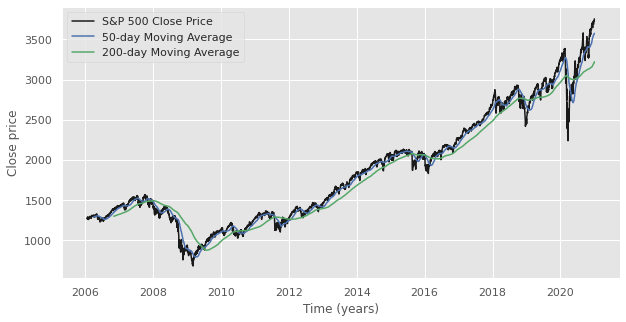

In [ ]:
df = data.copy()
#df['MA_20'] = df['Close'].rolling(20).mean()
df['MA_50'] = df['Close'].rolling(50).mean()
df['MA_200'] = df['Close'].rolling(200).mean()

fig = plt.figure(figsize=(10,5))
fig.set(facecolor = "white")
plt.plot(df['Close'], 'k',label=['S&P 500 Close Price'])
plt.plot(df['MA_50'],'b', label=['50-day MA'])
plt.plot(df['MA_200'],'g', label=['200-day MA'])
plt.legend(['S&P 500 Close Price', '50-day Moving Average', '200-day Moving Average'], loc='upper left')
plt.title('')
plt.xlabel('Time (years)')
plt.ylabel('Close price')
#sns.set_style("whitegrid")
fig.savefig('original_data_plus_moving_averages.png',dpi=600)
plt.show()

####  **Correlation heatmap**

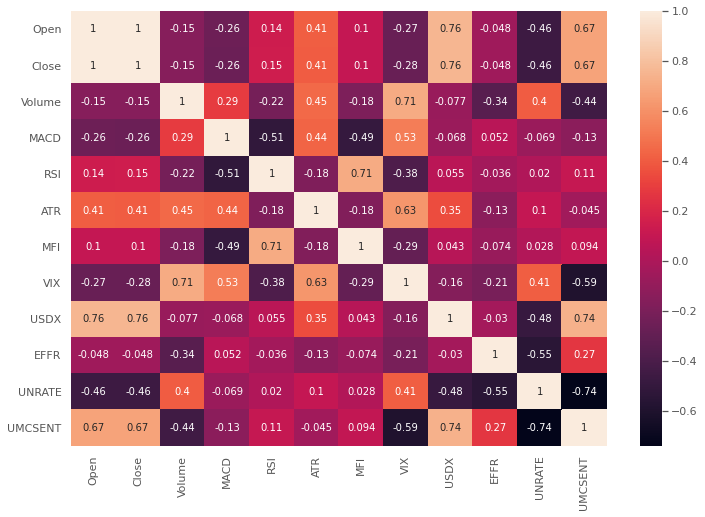

In [ ]:

fig = plt.figure(figsize= (12,8))
sns.heatmap(data.corr(), annot=True)
sns.set_style("whitegrid")
fig.savefig('correlation_heatmap.png',dpi=600)


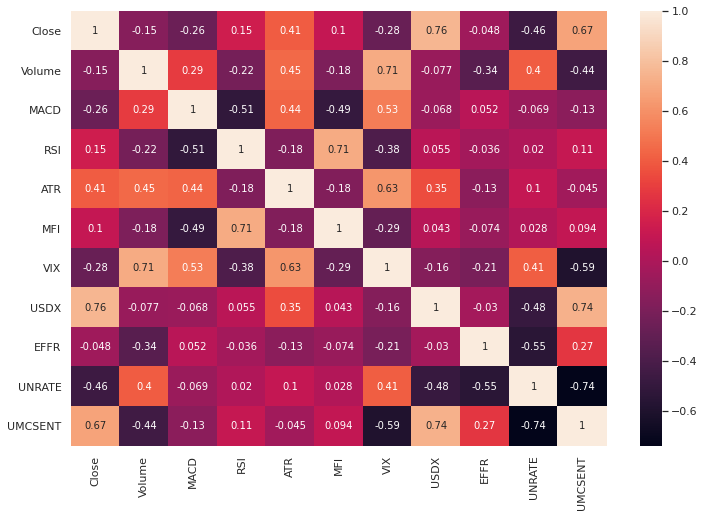

In [ ]:
data = data.iloc[:, 1:]
fig = plt.figure(figsize= (12,8))
sns.heatmap(data.corr(), annot=True)
sns.set_style("whitegrid")
fig.savefig('correlation_heatmap2.png',dpi=600)


<Figure size 1440x864 with 0 Axes>

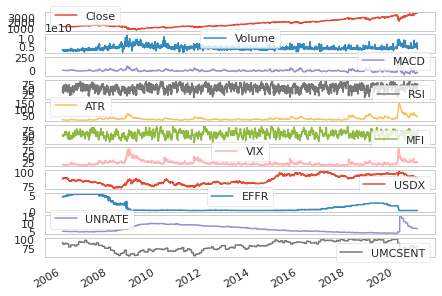

In [ ]:

fig = plt.figure(figsize = (20, 12))
#fig.axes.get_yaxis().set_visible(False)
data.plot(subplots = True, figsize = (7,5),grid=False)
sns.set_style("whitegrid")
fig.savefig('timeseries.png',dpi=600)
plt.show()

# **Part II: Building and Testing LSTM Models**

### **Machine learning libraries**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import time
import math


### **Supporting functions**

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return (np.mean(np.abs((y_true - y_pred)/(y_true))*100)) #some issues with zero denominator

def calculate_scores(y_true, y_pred):
  rmse = math.sqrt(mean_squared_error(y_true, y_pred))
  #R2_score = r2_score(y_true, y_pred)
  R = np.corrcoef(y_true, y_pred)
  #mae = mean_absolute_error(y_true, y_pred)
  mape = mean_absolute_percentage_error(y_true, y_pred)
  #dic = {'rmse':rmse, 'R2_score': R2_score, 'R':R[0,1], 'mae': mae, 'mape': mape}
  dic = {'rmse':rmse, 'R': R[0,1], 'mape': mape}
  return (dic)



def DatasetCreation(dataset, time_step = 1):  ##defining a function that gives a dataset and a time step, which then returns the input and output data
   DataX, DataY = [], []
   for i in range(len(dataset)- time_step -1):
         a = dataset[i:(i+ time_step), ]
         DataX.append(a)
         DataY.append(dataset[i + time_step, 0]) #ydata consists close price
   return np.array(DataX), np.array(DataY)


### **Supporting functions for results visualization**

In [ ]:
def error_plot(model_output):

  best_replicate = model_output['best_model']['replicate']

  fig = plt.figure(figsize = (6,4))
  #plt.subplot(121)
  for i in range(len(model_output['models_history'])):
    plt.plot(model_output['models_history'][i][best_replicate].history['loss'], '--o')
  plt.title("Training loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss(MSE)")
  plt.legend(['10 neurons', '30 neurons', '50 neurons', '100 neurons', '150 neurons', '200 neurons'], loc= 'upper right')
  sns.set_style("whitegrid")

  fig.savefig("train_error_plot.png",dpi=600)
  
def best_model_error_plot(model_output):
  fig = plt.figure(figsize = (8,6))
  #plt.subplot(121)
  plt.plot(model_output['best_model']['loss'], '--o')
  #plt.plot(model_output['best_model']['val_loss'], '--o')
  #plt.title("Trainin loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss(MSE)")
  #plt.legend(['Training loss'], loc= 'upper right')
  #plt.rcParams['axes.facecolor']='w'
  plt.grid(color='#F5F5DC')
  fig.savefig("best_model_train_val_error_plot.png",dpi=600)

def test_scores_plot(model_output):
  neurons = model_output['avg_scores']['neurons']
  rmse = model_output['avg_scores']['rmse']
  #mae =  model_output['avg_scores']['mae']
  mape =  model_output['avg_scores']['mape']
  #R2 =   model_output['avg_scores']['R2']
  R =    model_output['avg_scores']['R']
  time =  model_output['avg_scores']['elapsed_time']

  fig = plt.figure(figsize = (12, 10))
  plt.subplot(221)
  plt.plot(neurons, rmse, '--o')
  plt.title("(a)")
  plt.xlabel("Neurons")
  plt.ylabel("Avg. RMSE")
  sns.set_style("whitegrid")

  
  plt.subplot(222)
  plt.plot(neurons, mape, '--o')
  plt.title("(b)")
  plt.xlabel("Neurons")
  plt.ylabel("Avg. MAPE")


  plt.subplot(223)
  plt.plot(neurons, R, '--o')
  plt.title("(c)")
  plt.xlabel("Neurons")
  plt.ylabel("Avg. R ")


  plt.subplot(224)
  plt.plot(neurons, time, '--o')
  plt.title("(d)")
  plt.xlabel("Neurons")
  plt.ylabel("Avg. computing time (sec)")
  #fig.suptitle("Average test scores and computational time (sec)")
  fig.savefig("multiple_avg_scores_plots.png",dpi=600)
  plt.show()


def true_pred_plot(model_output):
  
  y_train = model_output['datasets']['y_train']
  y_test =  model_output['datasets']['y_test']

  train_pred = model_output['best_model']['train_predictions']
  test_pred = model_output['best_model']['test_predictions']

  ##====== Visualizing true vs predicted plots ========#
  fig = plt.figure(figsize= (12,4))
  plt.subplot(121)
  #sns.relplot(x = y_train_original, y = train_pred_original)
  plt.plot(y_train, train_pred, "o" )
  identity_line = np.linspace(max(min(y_train), min(train_pred)), min(max(y_train), max(train_pred)))
  plt.plot(identity_line, identity_line, color="blue", linestyle="dashed", linewidth=2.0)

  plt.xlabel("True")
  plt.ylabel("Predicted")
  plt.title("(a)")

  plt.subplot(122)
  #sns.relplot(x = y_test_original, y = test_pred_original)
  plt.plot(y_test, test_pred, "o")
  identity_line = np.linspace(max(min(y_test), min(test_pred)), min(max(y_test), max(test_pred)))
  plt.plot(identity_line, identity_line, color="blue", linestyle="dashed", linewidth=2.0)
  plt.xlabel("True")
  plt.ylabel("Predicted")
  plt.title("(b)")
  fig.savefig("True_vs_predicted_plot.png", dpi=600)
  plt.show()


def prediction_plot(model_output):
  time_step =  model_output['hyper_parameters']['time_step']
  best_replicate = model_output['best_model']['replicate']

  data = model_output['datasets']['data']

  train_predict_plot_data = np.empty_like(data.values[:,0])# extracting closing price
  train_predict_plot_data[:] = np.nan

  test_predict_plot_data = np.empty_like(data.values[:,0])
  test_predict_plot_data[:] = np.nan

  fig1 = plt.figure(figsize = (18,12))

  plt.subplot(231)

  train_pred = model_output['train_predictions'][0][best_replicate]
  test_pred = model_output['test_predictions'][0][best_replicate]


  train_predict_plot_data[time_step:len(train_pred)+ time_step] =  train_pred
  test_predict_plot_data[len(train_pred)+(time_step*2)+1:len(data.values)-1] = test_pred
  
  plt.plot(data.values[:,0],'k')
  plt.plot(train_predict_plot_data,'b')
  plt.plot(test_predict_plot_data,'g')
  plt.xlabel('')
  plt.ylabel('Close price')
  plt.title("(a)")
  plt.legend(['True value', 'Predicted value in train set', 'Predicted value in test set'], loc = 'upper left')

  plt.subplot(232)

  train_pred = model_output['train_predictions'][1][best_replicate]
  test_pred = model_output['test_predictions'][1][best_replicate]

  train_predict_plot_data[time_step:len(train_pred)+ time_step] =  train_pred 
  test_predict_plot_data[len(train_pred)+(time_step*2)+1:len(data.values)-1] =  test_pred

  plt.plot(data.values[:,0],'k')
  plt.plot(train_predict_plot_data,'b')
  plt.plot(test_predict_plot_data,'g')
  plt.xlabel('')
  plt.ylabel('Close price')
  plt.title("(b)")
  plt.legend(['True value', 'Predicted value in train set', 'Predicted value in test set'], loc = 'upper left')

  plt.subplot(233)

  train_pred = model_output['train_predictions'][2][best_replicate]
  test_pred = model_output['test_predictions'][2][best_replicate]

  train_predict_plot_data[time_step:len(train_pred)+ time_step] = train_pred
  test_predict_plot_data[len(train_pred)+(time_step*2)+1:len(data.values)-1] =  test_pred

  plt.plot(data.values[:,0],'k')
  plt.plot(train_predict_plot_data,'b')
  plt.plot(test_predict_plot_data,'g')
  plt.xlabel('')
  plt.ylabel('Close price')
  plt.title("(c)")
  plt.legend(['True value', 'Predicted value in train set', 'Predicted value in test set'], loc = 'upper left')


  plt.subplot(234)

  train_pred = model_output['train_predictions'][3][best_replicate]
  test_pred = model_output['test_predictions'][3][best_replicate]

  train_predict_plot_data[time_step:len(train_pred)+ time_step] = train_pred
  test_predict_plot_data[len(train_pred)+(time_step*2)+1:len(data.values)-1] = test_pred

  plt.plot(data.values[:,0],'k')
  plt.plot(train_predict_plot_data,'b')
  plt.plot(test_predict_plot_data,'g')
  plt.xlabel('')
  plt.ylabel('Close price')
  plt.title("(d)")
  plt.legend(['True value', 'Predicted value in train set', 'Predicted value in test set'], loc = 'upper left')
  

  plt.subplot(235)

  train_pred = model_output['train_predictions'][4][best_replicate]
  test_pred = model_output['test_predictions'][4][best_replicate]

  train_predict_plot_data[time_step:len(train_pred)+ time_step] = train_pred
  test_predict_plot_data[len(train_pred)+(time_step*2)+1:len(data.values)-1] = test_pred

  plt.plot(data.values[:,0],'k')
  plt.plot(train_predict_plot_data,'b')
  plt.plot(test_predict_plot_data,'g')
  plt.xlabel('')
  plt.ylabel('Close price')
  plt.title("(e)")
  plt.legend(['True value', 'Predicted value in train set', 'Predicted value in test set'], loc = 'upper left')

  plt.subplot(236)

  train_pred = model_output['train_predictions'][5][best_replicate]
  test_pred = model_output['test_predictions'][5][best_replicate]

  train_predict_plot_data[time_step:len(train_pred)+ time_step] = train_pred
  test_predict_plot_data[len(train_pred)+(time_step*2)+1:len(data.values)-1] = test_pred

  plt.plot(data.values[:,0],'k')
  plt.plot(train_predict_plot_data,'b')
  plt.plot(test_predict_plot_data,'g')
  plt.xlabel('')
  plt.ylabel('Close price')
  plt.title("(f)")
  plt.legend(['True value', 'Predicted value in train set', 'Predicted value in test set'], loc = 'upper left')


  fig1.savefig("predictions_plots_fullset.png",dpi=600)
  plt.show()

  fig2 = plt.figure(figsize = (18,12))

  plt.subplot(231)
  plt.plot(data.values[len(train_pred)+(time_step*2)+1:-1, 0],'b')
  plt.plot(model_output['test_predictions'][0][best_replicate], 'r')
  plt.xlabel('')
  plt.ylabel('Close price')
  plt.title("(a)")
  plt.legend(['True value', 'Predicted value'], loc='upper left')


  plt.subplot(232)

  plt.plot(data.values[len(train_pred)+(time_step*2)+1:-1, 0],'b')
  plt.plot(model_output['test_predictions'][1][best_replicate], 'r')
  plt.xlabel('')
  plt.ylabel('Close price')
  plt.title("(b)")
  plt.legend(['True value', 'Predicted value'], loc='upper left')


  plt.subplot(233)

  plt.plot(data.values[len(train_pred)+(time_step*2)+1:-1, 0],'b')
  plt.plot(model_output['test_predictions'][2][best_replicate], 'r')
  plt.xlabel('')
  plt.ylabel('Close price')
  plt.title("(c)")
  plt.legend(['True value', 'Predicted value'], loc='upper left')



  plt.subplot(234)

  plt.plot(data.values[len(train_pred)+(time_step*2)+1:-1, 0],'b')
  plt.plot(model_output['test_predictions'][3][best_replicate], 'r')
  plt.xlabel('')
  plt.ylabel('Close price')
  plt.title("(d)")
  plt.legend(['True value', 'Predicted value'], loc='upper left')
  
  plt.subplot(235)

  plt.plot(data.values[len(train_pred)+(time_step*2)+1:-1, 0],'b')
  plt.plot(model_output['test_predictions'][4][best_replicate], 'r')
  plt.xlabel('')
  plt.ylabel('Close price')
  plt.title("(e)")
  plt.legend(['True value', 'Predicted value'], loc='upper left')

  
  plt.subplot(236)

  plt.plot(data.values[len(train_pred)+(time_step*2)+1:-1, 0],'b')
  plt.plot(model_output['test_predictions'][5][best_replicate], 'r')
  plt.xlabel('')
  plt.ylabel('Close price')
  plt.title("(f)")
  plt.legend(['True value', 'Predicted value'], loc='upper left')



  fig2.savefig("predictions_plots_testset.png",dpi=600)

  plt.show()

def best_model_prediction_plot(model_output):

  time_step =  model_output['hyper_parameters']['time_step']

  data = model_output['datasets']['data']

  train_predict_plot_data = np.empty_like(data.values[:,0])# extracting closing price
  train_predict_plot_data[:] = np.nan

  test_predict_plot_data = np.empty_like(data.values[:,0])
  test_predict_plot_data[:] = np.nan

  
  fig = plt.figure(figsize = (12,5))

  plt.subplot(121)

  train_pred = model_output['best_model']['train_predictions']
  test_pred = model_output['best_model']['test_predictions']

  train_predict_plot_data[time_step:len(train_pred)+ time_step] =  train_pred
  test_predict_plot_data[len(train_pred)+(time_step*2)+1:len(data.values)-1] = test_pred
  
  plt.plot(data.values[:,0],'k')
  plt.plot(train_predict_plot_data,'b')
  plt.plot(test_predict_plot_data,'g')
  plt.xlabel('')
  plt.ylabel('Close price')
  plt.title("(a)")
  plt.legend(['True value', 'Predicted value in train set', 'Predicted value in test set'], loc = 'upper left')


  plt.subplot(122)
  plt.plot(data.values[len(train_pred)+(time_step*2)+1:-1, 0],'b')
  plt.plot(test_pred,'g')
  plt.xlabel('')
  plt.ylabel('Close price')
  plt.title("(b)")
  plt.legend(['True value', 'Predicted value'], loc='upper left')

  fig.savefig("best_model_predictions_plots.png",dpi=600)


def rmse_boxplots(model_output):
  fig = plt.figure(figsize = (6,4))
  plt.boxplot(model_output['scores']['rmse'])
  plt.xticks([1,2,3,4,5,6], ['10', '30', '50', '100', '150', '200'])
  plt.xlabel('Number of neurons')
  plt.ylabel('RMSE')
  fig.savefig("rmse_boxplots.png",dpi=600)
  plt.show()

def all_scores_boxplots(model_output):

  fig = plt.figure(figsize = (18,4))
  plt.subplot(131)
  plt.boxplot(model_output['scores']['rmse'])
  plt.xticks([1,2,3,4,5,6], ['10', '30', '50', '100', '150', '200'])
  plt.title("(a)")
  plt.xlabel('Number of neurons')
  plt.ylabel('RMSE')

  plt.subplot(132)
  plt.boxplot(model_output['scores']['mape'])
  plt.xticks([1,2,3,4,5,6], ['10', '30', '50', '100', '150', '200'])
  plt.title("(b)")
  plt.xlabel('Number of neurons')
  plt.ylabel('MAPE')

  plt.subplot(133)
  plt.boxplot(model_output['scores']['R'])
  plt.xticks([1,2,3,4,5,6], ['10', '30', '50', '100', '150', '200'])
  plt.title("(c)")
  plt.xlabel('Number of neurons')
  plt.ylabel('R')

  #plt.subplot(224)
  #plt.boxplot(model_output['scores']['elapsed_time'])
  #plt.xticks([1,2,3,4,5,6], ['10', '30', '50', '100', '150', '200'])
  #plt.title("(d)")
  #plt.xlabel('Number of neurons')
  #plt.ylabel('Elapsed_time')
  
  fig.savefig("all_scores_boxplots.png",dpi=600)
  plt.show()



def create_visualization(model_output):
  error_plot(model_output)
  best_model_error_plot(model_output)
  true_pred_plot(model_output)
  test_scores_plot(model_output)
  #prediction_plot(model_output)
  best_model_prediction_plot(model_output)
  rmse_boxplots(model_output)
  all_scores_boxplots(model_output)

  

#### **With Adam Optimizer**

In [ ]:
#========== Model hyper parameters settting ==========================#
def LSTM_model(neurons, data, time_step = 5, num_replicates = 3, epochs = 3,
               batch_size = 5, test_split = 0.2, optimizer = "Adam", 
               learning_rate = 0.001):
  #====== data transformation==========#
  print("Progress: Performing data preparation steps.......\n")

  #======= creating training and test data===#
  
  train_len   = int(len(data) * (1- test_split))
  test_len    = len(data) - train_len
  train_data  = data.iloc[0:train_len,:]
  test_data   = data.iloc[train_len:len(data),:]

  #val_len= int(len(train_data) * 0.1)

  train_scaler = MinMaxScaler(feature_range=(0, 1)) 
  train_data_scaled = train_scaler.fit_transform(train_data)

  test_scaler = MinMaxScaler(feature_range=(0, 1)) 
  test_data_scaled = test_scaler.fit_transform(test_data)


  #========dealing with time series=========#
  X_train, y_train = DatasetCreation(train_data_scaled, time_step)
  X_test, y_test = DatasetCreation(test_data_scaled, time_step)


  #===========Reshaping data for LSTM implementation:(num_train_samples, time_steps, num_features)===#
  num_train_samples  =  X_train.shape[0] 
  time_step    =  X_train.shape[1] #also given as argument
  num_features =  X_train.shape[2] 

  X_train = np.reshape(X_train, (num_train_samples, time_step, num_features))
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

  train_min_close = train_data["Close"].min()
  train_max_close = train_data["Close"].max()

  test_min_close = test_data["Close"].min()
  test_max_close = test_data["Close"].max()

  
  y_train_original  =     train_min_close + y_train*(train_max_close - train_min_close)
  y_test_original   =     test_min_close + y_test*(test_max_close - test_min_close)

  print("Progress: Building and training models.......\n")
  
  neurons = np.array(neurons)
  #============ arrays for collecting test scores ================#
  rmse_array = np.zeros((len(neurons), num_replicates))
  #mae_array  = np.zeros((len(neurons), num_replicates))
  mape_array = np.zeros((len(neurons), num_replicates))
  #R2_array   = np.zeros((len(neurons), num_replicates))
  R_array    = np.zeros((len(neurons), num_replicates))
  elapsed_time_array = np.zeros((len(neurons), num_replicates))

  

  #========== array for collecting history and predictions =======#
  models_history = []
  train_predictions = []
  test_predictions  = []

  if optimizer == 'Adam':
    opt = optimizers.Adam(learning_rate = learning_rate)
  elif optimizer == 'Adadelta':
    opt = optimizers.Adadelta(learning_rate= learning_rate)
  elif optimizer == 'RMSprop':
    opt = optimizers.RMSprop(learning_rate= learning_rate)
  else:
    print("No optimizer found in the list(['Adam','Adadelta', 'RMSprop'])! Please apply your optimizer manually...")


  for i in range(len(neurons)):

    #========== saving history and predictions per replicate=====#
    model_history_per_replicate = []
    train_predictions_per_replicate = []
    test_predictions_per_replicate  = []
     
    hidden_nodes = np.int(neurons[i])
   # print("Program is running for %d neurons ----->\n" %np.int(neurons[i]))
    for k in range(num_replicates):
      print("Program is running for %d neurons and %d replicate ----->\n" %(hidden_nodes, k))
      model = Sequential()
      model.add(LSTM(hidden_nodes, time_major = False))
      model.add(Dense(1, activation = 'linear'))
      model.compile(loss='mean_squared_error', optimizer = opt)
    
      start = time.time()
      history = model.fit(X_train, y_train, epochs= epochs, batch_size = batch_size, verbose = 1)
      end = time.time()
      elapsed_time = end - start
      
      model_history_per_replicate.append(history)

      #train_loss_history[i][k].append(history.history['loss'])
      #val_loss_history[i][k].append(history.history['val_loss'])

      #==============Making train and test prediction==========
      train_pred  = model.predict(X_train).ravel()
      test_pred   = model.predict(X_test).ravel()

      #==============Making train and test prediction in original scales ==========
      
      train_pred_original =   train_min_close + train_pred*(train_max_close - train_min_close)
      test_pred_original  =   test_min_close + test_pred*(test_max_close - test_min_close)
      
      train_predictions_per_replicate.append(train_pred_original)
      test_predictions_per_replicate.append(test_pred_original)

      #train_scores = calculate_scores(y_train_original, train_pred_original)
      scores =  calculate_scores(y_test_original, test_pred_original)

      rmse_array[i][k] = scores['rmse']
      #mae_array[i][k] =  scores['mae']
      mape_array[i][k] =  scores['mape']
      #R2_array[i][k] = scores['R2_score']
      R_array[i][k] = scores['R']
      elapsed_time_array[i][k] = elapsed_time

    models_history.append(model_history_per_replicate)
    train_predictions.append(train_predictions_per_replicate)
    test_predictions.append(test_predictions_per_replicate)

  print("Progress: Collecting outputs.......\n")

  neurons_df = pd.DataFrame(neurons)
  rmse_df = pd.DataFrame(rmse_array) 
  #mae_df  = pd.DataFrame(mae_array)
  mape_df  = pd.DataFrame(mape_array) 
  #R2_df   = pd.DataFrame(R2_array) 
  R_df    = pd.DataFrame(R_array) 
  elapsed_time_df =  pd.DataFrame(elapsed_time_array)

  train_predictions  = np.array(train_predictions)
  test_predictions   = np.array(test_predictions)
 
  #==== Idendifying  the best model results based on rmse ===============#
  min_index = pd.DataFrame(rmse_df.min(axis = 1)).idxmin()[0] 
  min_col =   pd.DataFrame(rmse_df.min(axis = 0)).idxmin()[0]
  
  num_neurons_with_best_rmse = neurons_df.loc[min_index,0]

  best_rmse = rmse_df.loc[min_index, min_col]
  #mae_with_best_rmse = mae_df.loc[min_index, min_col]
  mape_with_best_rmse = mape_df.loc[min_index, min_col]
  #R2_with_best_rmse = R2_df.loc[min_index, min_col]
  R_with_best_rmse =  R_df.loc[min_index, min_col]
  elapsed_time_with_best_rmse = elapsed_time_df.loc[min_index, min_col]

  train_predictions_with_best_rmse = train_predictions[min_index][min_col]
  test_predictions_with_best_rmse = test_predictions[min_index][min_col]

  loss_with_best_rmse = models_history[min_index][min_col].history['loss']
  #val_loss_with_best_rmse = models_history[min_index][min_col].history['val_loss']

  #======= Collecting hyperparameters=============#                           
  hyper_parameters = { 'neurons': neurons,
                       'epochs': epochs,
                       'optimizer': optimizer,
                       'learning_rate':learning_rate,
                       'time_step':time_step,
                       'batch_size':batch_size,
                       'num_replicates': num_replicates,
                       'test_split':test_split
                       #'validataion_split':validation_split
                        }

  #======= Collecting test scores =============#    
  #scores = {'neurons': neurons_df, 'rmse': rmse_df, 'mae': mae_df,  'mape': mape_df,'R2': R2_df, 'R': R_df,  'elapsed_time': elapsed_time_df}
  scores = {'neurons': neurons_df, 'rmse': rmse_df, 'mape': mape_df, 'R': R_df, 'elapsed_time': elapsed_time_df}

  #======= Collecting average test scores =============#  
  avg_scores = pd.DataFrame({'neurons': neurons,
                            'rmse': rmse_df.mean(axis = 1),
                            #'mae': mae_df.mean(axis = 1), 
                            'mape': mape_df.mean(axis = 1), 
                            #'R2': R2_df.mean(axis = 1),
                            'R': R_df.mean(axis = 1), 
                            'elapsed_time': elapsed_time_df.mean(axis = 1)})
  
 #======= Collecting average test scores =============#  
  all_stds = pd.DataFrame({'neurons': neurons,
                            'rmse': rmse_df.std(axis = 1),
                            #'mae': mae_df.mean(axis = 1), 
                            'mape': mape_df.std(axis = 1), 
                            #'R2': R2_df.mean(axis = 1),
                            'R': R_df.std(axis = 1), 
                            'elapsed_time': elapsed_time_df.std(axis = 1)})
  
   
 #======= Collecting average test scores =============#  
  all_minimums = pd.DataFrame({'neurons': neurons,
                            'rmse': rmse_df.min(axis = 1),
                            #'mae': mae_df.mean(axis = 1), 
                            'mape': mape_df.min(axis = 1), 
                            #'R2': R2_df.mean(axis = 1),
                            'R': R_df.min(axis = 1), 
                            'elapsed_time': elapsed_time_df.min(axis = 1)})
  
  #======= Collecting average test scores =============#  
  all_maximums = pd.DataFrame({'neurons': neurons,
                            'rmse': rmse_df.max(axis = 1),
                            #'mae': mae_df.mean(axis = 1), 
                            'mape': mape_df.max(axis = 1), 
                            #'R2': R2_df.mean(axis = 1),
                            'R': R_df.max(axis = 1), 
                            'elapsed_time': elapsed_time_df.max(axis = 1)})
  
  

  #======= Collecting the best model results =============#  
  model_with_best_rmse = {  'neurons': num_neurons_with_best_rmse,
                            'replicate': min_col,
                            'rmse': best_rmse,
                            #'mae': mae_with_best_rmse,
                            'mape': mape_with_best_rmse,
                            #'R2': R2_with_best_rmse,
                            'R':  R_with_best_rmse,
                            'elapsed_time': elapsed_time_with_best_rmse,
                            'train_predictions':train_predictions_with_best_rmse,
                            'test_predictions': test_predictions_with_best_rmse,
                            'loss':loss_with_best_rmse,
                            #'val_loss': val_loss_with_best_rmse
                         }

  datasets  =    {'data': data, 
                  'X_train': X_train,
                  'X_test': X_test,
                  'y_train': y_train_original,
                  'y_test': y_test_original
                  }
                
  #======= Collecting all the outputs together =============#  
  output_dictionary = { 'hyper_parameters': hyper_parameters,
                        'best_model': model_with_best_rmse,
                        'scores': scores,
                        'avg_scores': avg_scores,
                        'all_stds': all_stds,
                        'all_minimums': all_minimums,
                        'all_maximums': all_maximums,
                        'train_predictions': train_predictions,
                        'test_predictions':  test_predictions,
                        'models_history': models_history,
                        'datasets': datasets
                       }

  print("\nBest model (neurons, replicate, rmse): ", num_neurons_with_best_rmse, min_col, best_rmse)
  print('\nAverage scores:\n', avg_scores)
  print('\nStandard_deviations:\n', all_stds)
  print('\nMinimums:\n', all_minimums)
  print('\nMaximums:\n', all_maximums)
  print("\nProgress: All works are done successfully, congratulations!!\n")

  return (output_dictionary)


## **Single Layer LSTM with 10, 30, 50, 100, 150, 200 neurons**
- Time_step= 5 
- Epochs = 30
- Batch size = 16
- Replicates = 30

#### **Task: Binod Sir**

In [ ]:
#neurons = np.array([10, 30, 50, 100, 150,200])
#model_output = LSTM_model(neurons, data, time_step = 5, num_replicates = 2 , epochs = 5, batch_size = 16, test_split = 0.2, optimizer = "Adam", learning_rate = 0.001)

In [ ]:
#create_visualization(model_output)


# **Multi-Layer LSTM Model**

###  **Multi-Layer Model Visualization Functions**

In [ ]:
def multi_layers_error_plot(model_output):

  fig = plt.figure(figsize = (6,4))
  plt.plot(model_output['best_model']['loss'], '--o')
  #plt.plot(model_output['best_model']['val_loss'], ':o')
  plt.title("Training and validation losses")
  plt.xlabel("Epochs")
  plt.ylabel("Loss(MSE)")
  sns.set_style("whitegrid")
  #plt.legend(['Training loss', 'Validation loss'], loc='upper right')
  fig.savefig("multi_layers_train_val_error_plot.png")
  plt.show()


def multi_layers_true_pred_plot(model_output):
  
  y_train = model_output['datasets']['y_train']
  y_test =  model_output['datasets']['y_test']

  train_pred = model_output['best_model']['train_predictions']
  test_pred = model_output['best_model']['test_predictions']

  ##====== Visualizing true vs predicted plots ========#
  fig = plt.figure(figsize= (12,4))
  plt.subplot(121)
  #sns.relplot(x = y_train_original, y = train_pred_original)
  plt.plot(y_train, train_pred, "o" )
  identity_line = np.linspace(max(min(y_train), min(train_pred)), min(max(y_train), max(train_pred)))
  plt.plot(identity_line, identity_line, color="blue", linestyle="dashed", linewidth=3.0)

  plt.xlabel("True")
  plt.ylabel("Predicted")
  plt.title("(a)")

  plt.subplot(122)
  #sns.relplot(x = y_test_original, y = test_pred_original)
  plt.plot(y_test, test_pred, "o")
  identity_line = np.linspace(max(min(y_test), min(test_pred)), min(max(y_test), max(test_pred)))
  plt.plot(identity_line, identity_line, color="blue", linestyle="dashed", linewidth=3.0)
  plt.xlabel("True")
  plt.ylabel("Predicted")
  plt.title("(b)")
  fig.savefig("multi_layers_true_vs_predicted_plot.png")
  plt.show()


def multi_layers_prediction_plot(model_output):

  time_step = model_output['hyper_parameters']['time_step']
  best_replicate = model_output['best_model']['replicate']

  data = model_output['datasets']['data']

  train_predict_plot_data = np.empty_like(data.values[:,0])# extracting closing price
  train_predict_plot_data[:] = np.nan

  test_predict_plot_data = np.empty_like(data.values[:,0])
  test_predict_plot_data[:] = np.nan


  train_pred = model_output['train_predictions'][best_replicate]
  test_pred = model_output['test_predictions'][best_replicate]


  train_predict_plot_data[time_step:len(train_pred)+ time_step] =  train_pred
  test_predict_plot_data[len(train_pred)+(time_step*2)+1:len(data.values)-1] = test_pred
  
  fig = plt.figure(figsize = (16,8))
  plt.subplot(121)
  plt.plot(data.values[:,0])
  plt.plot(train_predict_plot_data)
  plt.plot(test_predict_plot_data)
  plt.xlabel('')
  plt.ylabel('Close price')
  plt.title("(a)")
  plt.legend(['True value', 'Predicted value in train set', 'Predicted value in test set'], loc = 'upper left')

  
  plt.subplot(122)
  plt.plot(data.values[len(train_pred)+(time_step*2)+1:-1, 0])
  plt.plot(model_output['test_predictions'][best_replicate], 'g')
  plt.xlabel('')
  plt.ylabel('Close price')
  plt.title("(b)")
  plt.legend(['True value', 'Predicted value'], loc='upper left')

  fig.savefig("multi_layers_predictions_plots_testset.png")

  plt.show()


def multi_layers_visualization(model_output):
  multi_layers_error_plot(model_output)
  multi_layers_true_pred_plot(model_output)
  multi_layers_prediction_plot(model_output)
  

### **Building and Compiling Multi-layers LSTM Models** 

In [ ]:
def build_model(layers, time_step, num_features, optimizer = 'Adam', learning_rate = 0.001, verbose = 1):
  
  model = Sequential()
    
  for i in range(len(layers)):
    if len(layers)==1:
      model.add(LSTM(np.int(layers[i]), input_shape = (time_step, num_features)))
    else:
      if i < len(layers)-1:
        if i == 0:
          model.add(LSTM(np.int(layers[i]), input_shape=(time_step, num_features), return_sequences= True))
          #model.add(Dropout(0.10))
        else:
          model.add(LSTM(np.int(layers[i]), return_sequences=True))
          #model.add(Dropout(0.10))
      else:
        model.add(LSTM(np.int(layers[i])))
        #model.add(Dropout(0.10))  
  model.add(Dense(1, activation = 'linear'))
  
  if optimizer == 'Adam':
    opt = optimizers.Adam(learning_rate = learning_rate)
  elif optimizer == 'Adadelta':
    opt = optimizers.Adadelta(learning_rate= learning_rate)
  elif optimizer == 'RMSprop':
    opt = optimizers.RMSprop(learning_rate= learning_rate)
  else:
    print("No optimizer found in the list(['Adam','Adadelta', 'RMSprop'])! Please apply your optimizer manually...")

  model.compile(loss='mean_squared_error', optimizer= opt)
   
  if verbose == 1:
    print(model.summary())
  return model

In [ ]:
#build_model([250], 20, 11, 'Adam', 0.001, 1)

### **Training Multi-Layers LSTM Models**

In [ ]:
 
def multi_layer_LSTM_Model(data, layers, time_step = 20, num_replicates = 30, epochs = 30, batch_size = 16, test_split = 0.2, optimizer = 'Adam', learning_rate = 0.001, verbose = 0):
   
    train_len   = int(len(data) * (1- test_split))
    test_len    = len(data) - train_len
    train_data  = data.iloc[0:train_len,:]
    test_data   = data.iloc[train_len:len(data),:]

    ##splitting validation set
    #val_len = int(len(train_data) * 0.1)

    train_scaler = MinMaxScaler(feature_range=(0, 1)) 
    train_data_scaled = train_scaler.fit_transform(train_data)
  
    test_scaler = MinMaxScaler(feature_range=(0, 1)) 
    test_data_scaled = test_scaler.fit_transform(test_data)
   
    #========dealing with time series=========#
    X_train, y_train = DatasetCreation(train_data_scaled, time_step)
    # X_val, y_val=DatasetCreation(val_data_scaled, time_step)
    X_test, y_test = DatasetCreation(test_data_scaled, time_step)
    
    #===========Reshaping data for LSTM implementation:(num_train_samples, time_steps, num_features)===#
    num_train_samples  =  X_train.shape[0] 
    time_step    =  X_train.shape[1] #also given as argument
    num_features =  X_train.shape[2] 

    #Just making sure about the LSTM dimensions
    X_train = np.reshape(X_train, (num_train_samples, time_step, num_features))
    #X_val=np.reshape(X_val, (X_val.shape[0], X_val.shape[1], X_val.shape[2]))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))
     
    train_min_close = train_data["Close"].min()
    train_max_close = train_data["Close"].max()

    test_min_close = test_data["Close"].min()
    test_max_close = test_data["Close"].max()

    y_train_original  =     train_min_close + y_train*(train_max_close - train_min_close)
    y_test_original   =     test_min_close + y_test*(test_max_close - test_min_close)
  
    #============ arrays for collecting test scores ================#
    rmse_array = np.zeros(num_replicates)
    mape_array = np.zeros(num_replicates)
    R_array    = np.zeros(num_replicates)
    elapsed_time_array = np.zeros(num_replicates)

    models_history = []
    train_predictions = []
    test_predictions = []

    for i in range(num_replicates):

      print("Program is running for %d replicate ----->\n" %i)

      model = build_model(layers, time_step, num_features, optimizer, learning_rate, 0)
      
      start = time.time()
      #history = model.fit(X_train[0:(train_len-val_len),:,:], y_train[0:(train_len-val_len)], epochs= epochs, batch_size = batch_size, validation_data= (X_train[-val_len:,:,:], y_train[-val_len:]), verbose=1)
      history = model.fit(X_train, y_train, epochs= epochs, batch_size = batch_size, verbose=1)
      end = time.time()
      elapsed_time = end - start

      models_history.append(history)
      
      #==============Making train and test prediction==========
      train_pred  = model.predict(X_train).ravel()
      test_pred   = model.predict(X_test).ravel()

      #==============Making train and test prediction in original scales ==========
      
      train_pred_original =   train_min_close + train_pred*(train_max_close - train_min_close)
      test_pred_original  =   test_min_close + test_pred*(test_max_close - test_min_close)
      
      train_predictions.append(train_pred_original)
      test_predictions.append(test_pred_original)

      #train_scores = calculate_scores(y_train_original, train_pred_original)
      scores =  calculate_scores(y_test_original, test_pred_original)

       
      rmse_array[i] =  scores['rmse']
      mape_array[i] =  scores['mape']
      R_array[i] = scores['R']
      elapsed_time_array[i] = elapsed_time

    min_index = rmse_array.argmin()
    best_rmse = rmse_array[min_index]
    mape_with_best_rmse = mape_array[min_index]
    R_with_best_rmse =  R_array[min_index]
    elapsed_time_with_best_rmse = elapsed_time_array[min_index]

    train_predictions_with_best_rmse = train_predictions[min_index]
    test_predictions_with_best_rmse = test_predictions[min_index]

    loss_with_best_rmse = models_history[min_index].history['loss']

    #val_loss_with_best_rmse = models_history[min_index].history['val_loss']



    #======= Collecting average test scores =============# 
    all_scores = {'rmse': rmse_array, 'mape': mape_array, 'R': R_array, 'elapsed_time': elapsed_time_array}

    avg_scores = {'rmse': np.mean(rmse_array),
                  'mape': np.mean(mape_array),
                  'R': np.mean(R_array), 
                  'elapsed_time': np.mean(elapsed_time_array)}

    #======= Collecting standard deviations of scores =============#  
    stds = {'rmse': np.std(rmse_array),
              'mape': np.std(mape_array),
                  'R': np.std(R_array), 
                  'elapsed_time': np.std(elapsed_time_array)}
   
     #======= Collecting minimum values of test scores =============#  
    minimums = {'rmse': np.min(rmse_array),
                'mape': np.min(mape_array),
                'R': np.min(R_array), 
                'elapsed_time': np.min(elapsed_time_array)}
   
  
     
     #======= Collecting maximum values of test scores =============#  
    maximums = {'rmse': np.max(rmse_array),
                'mape': np.max(mape_array),
                'R': np.max(R_array), 
                'elapsed_time': np.max(elapsed_time_array)}
   
  
    model_with_best_rmse = {
                            'replicate': min_index,
                            'rmse': best_rmse,
                            #'mae': mae_with_best_rmse,
                            'mape': mape_with_best_rmse,
                            #'R2': R2_with_best_rmse,
                            'R':  R_with_best_rmse,
                            'elapsed_time': elapsed_time_with_best_rmse,
                            'train_predictions':train_predictions_with_best_rmse,
                            'test_predictions': test_predictions_with_best_rmse,
                            'loss':loss_with_best_rmse,
                            #'val_loss': val_loss_with_best_rmse
                         }
     #======= Collecting hyperparameters=============#                           
    hyper_parameters = { 'layers': layers,
                       'epochs': epochs,
                       'optimizer': optimizer,
                       'learning_rate':learning_rate,
                       'time_step':time_step,
                       'batch_size':batch_size,
                       'num_replicates': num_replicates,
                       'test_split':test_split
                        }

                
    
    datasets  =   {'data': data, 
                  'X_train': X_train,
                  'X_test': X_test,
                  'y_train': y_train_original,
                  'y_test': y_test_original
                  }
                
    #======= Collecting all the outputs together =============#  
    output_dictionary = {'hyper_parameters': hyper_parameters,
                        'best_model': model_with_best_rmse,
                        'all_scores': all_scores,
                        'avg_scores': avg_scores,
                        'standard deviations': stds,
                        'minimums': minimums, 
                        'maximums': maximums, 
                        'train_predictions': train_predictions,
                        'test_predictions':  test_predictions,
                        #'models_history': models_history,
                        'datasets': datasets 
                       }
    print("\n Best replicate and its rmse):\n",  min_index, best_rmse)
    print('\nAverage scores:\n', avg_scores)
    print('\nStandard_deviations:\n', stds)
    print('\nMinimums:\n', minimums)
    print('\nMaximums:\n', maximums)
    print("Progress: All works are done successfully, congratulations!!\n")
    return output_dictionary


In [ ]:
hidden_layers = [[10, 5], [20, 10], [50, 20], [100, 50], [150, 100], [100, 50, 20]]

def run_multi_layer_LSTM_Model(data, hidden_layers, time_step = 5, num_replicates = 3, epochs = 30, batch_size = 16, test_split = 0.2, optimizer = 'Adam', learning_rate = 0.001, verbose = 0):
  
  num_models = len(hidden_layers)

  #== to collect all scores===#
  rmse = []
  mape = []
  R = []
  elapsed_time = []

  #===to collect all avg scores===#
  avg_rmse = []
  avg_mape = []
  avg_R = []
  avg_elapsed_time = []
  
  #=== to iteratively update the best rmse and the corresponding model
  best_avg_rmse = 99999999999
  best_rmse = 99999999999
  best_model_hidden_layers = None
  best_model_output = None
  
  for i in range(num_models):
    print("Running model with hidden neurons: ", hidden_layers[i])
    print("\n")
    output = multi_layer_LSTM_Model(data, hidden_layers[i], time_step, num_replicates, epochs, batch_size, test_split, optimizer, learning_rate, verbose)
    
    rmse.append(output['all_scores']['rmse'])
    mape.append(output['all_scores']['mape'])
    R.append(output['all_scores']['R'])
    elapsed_time.append(output['all_scores']['elapsed_time'])

    avg_rmse.append(output['avg_scores']['rmse'])
    avg_mape.append(output['avg_scores']['mape'])
    avg_R.append(output['avg_scores']['R'])
    avg_elapsed_time.append(output['avg_scores']['elapsed_time'])
  
    if avg_rmse[i] < best_avg_rmse:
      best_avg_rmse = avg_rmse[i]
      best_rmse = output['best_model']['rmse']
      best_model_hidden_layers = hidden_layers[i] 
      best_model_output = output


  rmse = np.array(rmse)
  mape = np.array(mape)
  R =  np.array(R)

  # ===== Collecting all  scores================================#
  scores = {'layers': hidden_layers, 'rmse': rmse, 'mape': mape, 'R':R, 'elapsed_time': elapsed_time}

  # ======= Collecting avg scores ===============================#
  avg_scores = pd.DataFrame({'layers': hidden_layers, 'rmse': np.array(avg_rmse), 'mape': np.array(avg_mape), 'R':np.array(avg_R), 'elapsed_time':np.array(avg_elapsed_time)})
  
  #======= Collecting standard deviations of scores =============#  
  stds = pd.DataFrame({'layers': hidden_layers, 'rmse': np.std(rmse, axis = 1), 'mape': np.std(mape, axis = 1), 'R':  np.std(R, axis = 1 ),  'elapsed_time': np.std(elapsed_time, axis = 1 )})
   
  #======= Collecting minimum values of test scores =============#  
  minimums = pd.DataFrame({'layers': hidden_layers, 'rmse': np.min(rmse, axis =1 ), 'mape': np.min(mape, axis= 1), 'R': np.min(R, axis =1), 'elapsed_time': np.min(elapsed_time, axis =1)})
     
  #======= Collecting maximum values of test scores =============#  
  maximums = pd.DataFrame({'layers': hidden_layers, 'rmse': np.max(rmse, axis =1), 'mape': np.max(mape, axis =1), 'R': np.max(R, axis =1),  'elapsed_time': np.max(elapsed_time,axis =1)})

  output_dictionary = {
                     'scores': scores,
                     'avg_scores': avg_scores,
                     'stds':stds,
                     'minimums': minimums,
                     'maximums': maximums,
                      'best_avg_rmse': best_avg_rmse, 
                      'best_rmse': best_rmse, 
                      'best_model_hidden_layers': best_model_hidden_layers, 
                      'best_model_output': best_model_output                                
                      }


  print("\n Best model and its avg rmse and minimum rmse):\n", best_model_hidden_layers, best_avg_rmse, best_rmse)
  print('\nAverage scores:\n', avg_scores)
  print('\nStandard_deviations:\n', stds)
  print('\nMinimums:\n', minimums)
  print('\nMaximums:\n', maximums)

  print("Progress: All works are done successfully, congratulations!!\n")

  return output_dictionary                                 



In [ ]:
hidden_layers = [[10, 5], [20, 10], [50, 20], [100, 50], [150, 100], [100, 50, 20]]

model_output = run_multi_layer_LSTM_Model(data, hidden_layers,time_step = 5, num_replicates = 30, epochs = 30, batch_size = 16, test_split = 0.2, optimizer = 'Adam', learning_rate = 0.001, verbose = 0) 


Running model with hidden neurons:  [10, 5]


Program is running for 0 replicate ----->

Epoch 1/30
186/186 [==============================] - 9s 4ms/step - loss: 0.0293
Epoch 2/30
186/186 [==============================] - 1s 4ms/step - loss: 0.0018
Epoch 3/30
186/186 [==============================] - 1s 3ms/step - loss: 8.4148e-04
Epoch 4/30
186/186 [==============================] - 1s 4ms/step - loss: 4.7090e-04
Epoch 5/30
186/186 [==============================] - 1s 3ms/step - loss: 3.6155e-04
Epoch 6/30
186/186 [==============================] - 1s 4ms/step - loss: 2.9706e-04
Epoch 7/30
186/186 [==============================] - 1s 4ms/step - loss: 2.4936e-04
Epoch 8/30
186/186 [==============================] - 1s 3ms/step - loss: 2.1343e-04
Epoch 9/30
186/186 [==============================] - 1s 3ms/step - loss: 1.9115e-04
Epoch 10/30
186/186 [==============================] - 1s 3ms/step - loss: 1.9615e-04
Epoch 11/30
186/186 [==============================] - 1s 4ms/step -

In [ ]:
def multi_layers_all_scores_boxplots(model_output):

  fig = plt.figure(figsize = (18,4))
  plt.subplot(131)
  plt.boxplot(pd.DataFrame(model_output['scores']['rmse']))
  plt.xticks([1,2,3,4,5,6], ['(10, 5)', '(20, 10)', '(50, 20)', '(100, 50)', '(150, 100)', '(100, 50, 20)'], rotation = 75)
  plt.title("(a)")
  plt.xlabel('Number of neurons')
  plt.ylabel('RMSE')

  plt.subplot(132)
  plt.boxplot(pd.DataFrame(model_output['scores']['mape']))
  plt.xticks([1,2,3,4,5,6], ['(10, 5)', '(20, 10)', '(50, 20)', '(100, 50)', '(150, 100)', '(100, 50, 20)'],  rotation = 75)
  plt.title("(b)")
  plt.xlabel('Number of neurons')
  plt.ylabel('MAPE')

  plt.subplot(133)
  plt.boxplot(pd.DataFrame(model_output['scores']['R']))
  plt.xticks([1,2,3,4,5,6], ['(10, 5)', '(20, 10)', '(50, 20)', '(100, 50)', '(150, 100)', '(100, 50, 20)'],  rotation = 75)
  plt.title("(c)")
  plt.xlabel('Number of neurons')
  plt.ylabel('R')
  
  fig.savefig("multi_layers_all_scores_boxplots.png",dpi=600)
  plt.show()


In [ ]:
multi_layers_all_scores_boxplots(model_output)